## About the Dataset:

1. id: unique id for a news article
2. title: the title of a news article 
3. author: author of the news article 
4. text: the text of the article(could be incomplete)
5. label: a label that marks whether the news article is Real or Fake:

   1: Fake News, 
   0: Real News

### Importing the Required Libraries

In [2]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# printing the stopwords in English
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### Data Pre-processing and Analysis

In [5]:
# loading the dataset to a pandas DataFrame
news_data = pd.read_csv('train_news.csv')

In [6]:
# no. of rows and columns
news_data.shape

(20800, 5)

In [7]:
# print the first 5 rows of the dataframe
news_data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [8]:
# counting the number of missing values in the dataset
news_data.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [9]:
# replacing the null values with empty string
news_data = news_data.fillna('')

In [10]:
# merging the author name and news title
news_data['content'] = news_data['author']+' '+news_data['title']

In [11]:
print(news_data['content'])

0        Darrell Lucus House Dem Aide: We Didn’t Even S...
1        Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
2        Consortiumnews.com Why the Truth Might Get You...
3        Jessica Purkiss 15 Civilians Killed In Single ...
4        Howard Portnoy Iranian woman jailed for fictio...
                               ...                        
20795    Jerome Hudson Rapper T.I.: Trump a ’Poster Chi...
20796    Benjamin Hoffman N.F.L. Playoffs: Schedule, Ma...
20797    Michael J. de la Merced and Rachel Abrams Macy...
20798    Alex Ansary NATO, Russia To Hold Parallel Exer...
20799              David Swanson What Keeps the F-35 Alive
Name: content, Length: 20800, dtype: object


In [12]:
# separating the data & label
X = news_data.drop(columns='label', axis=1)
Y = news_data['label']

In [13]:
print(X)
print(Y)

          id                                              title  \
0          0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1          1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2          2                  Why the Truth Might Get You Fired   
3          3  15 Civilians Killed In Single US Airstrike Hav...   
4          4  Iranian woman jailed for fictional unpublished...   
...      ...                                                ...   
20795  20795  Rapper T.I.: Trump a ’Poster Child For White S...   
20796  20796  N.F.L. Playoffs: Schedule, Matchups and Odds -...   
20797  20797  Macy’s Is Said to Receive Takeover Approach by...   
20798  20798  NATO, Russia To Hold Parallel Exercises In Bal...   
20799  20799                          What Keeps the F-35 Alive   

                                          author  \
0                                  Darrell Lucus   
1                                Daniel J. Flynn   
2                             Consortiu

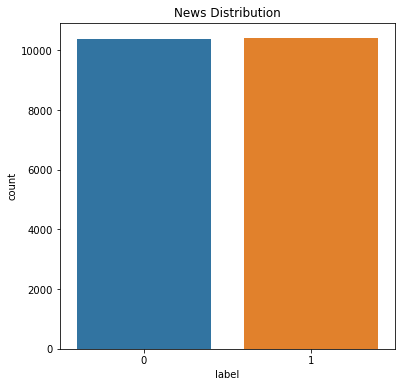

In [14]:
# label column
plt.figure(figsize=(6,6))
sns.countplot(x='label', data=news_data)
plt.title('News Distribution')
plt.show()

In [15]:
news_data['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

#### Stemming:

* Stemming is the process of reducing a word to its Root word
* example: actor, actress, acting --> act

In [16]:
port_stem = PorterStemmer()

In [17]:
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]',' ', content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [18]:
news_data['content'] = news_data['content'].apply(stemming)

In [19]:
print(news_data['content'])

0        darrel lucu hous dem aid even see comey letter...
1        daniel j flynn flynn hillari clinton big woman...
2                   consortiumnew com truth might get fire
3        jessica purkiss civilian kill singl us airstri...
4        howard portnoy iranian woman jail fiction unpu...
                               ...                        
20795    jerom hudson rapper trump poster child white s...
20796    benjamin hoffman n f l playoff schedul matchup...
20797    michael j de la merc rachel abram maci said re...
20798    alex ansari nato russia hold parallel exercis ...
20799                            david swanson keep f aliv
Name: content, Length: 20800, dtype: object


In [20]:
#separating the data and label
X = news_data['content'].values
Y = news_data['label'].values

In [21]:
print(X)

['darrel lucu hous dem aid even see comey letter jason chaffetz tweet'
 'daniel j flynn flynn hillari clinton big woman campu breitbart'
 'consortiumnew com truth might get fire' ...
 'michael j de la merc rachel abram maci said receiv takeov approach hudson bay new york time'
 'alex ansari nato russia hold parallel exercis balkan'
 'david swanson keep f aliv']


In [22]:
print(Y)

[1 0 1 ... 0 1 1]


In [23]:
# converting the textual data to numerical data
vectorizer = TfidfVectorizer()
vectorizer.fit(X)

X = vectorizer.transform(X)

In [24]:
print(X)

  (0, 15686)	0.28485063562728646
  (0, 13473)	0.2565896679337957
  (0, 8909)	0.3635963806326075
  (0, 8630)	0.29212514087043684
  (0, 7692)	0.24785219520671603
  (0, 7005)	0.21874169089359144
  (0, 4973)	0.233316966909351
  (0, 3792)	0.2705332480845492
  (0, 3600)	0.3598939188262559
  (0, 2959)	0.2468450128533713
  (0, 2483)	0.3676519686797209
  (0, 267)	0.27010124977708766
  (1, 16799)	0.30071745655510157
  (1, 6816)	0.1904660198296849
  (1, 5503)	0.7143299355715573
  (1, 3568)	0.26373768806048464
  (1, 2813)	0.19094574062359204
  (1, 2223)	0.3827320386859759
  (1, 1894)	0.15521974226349364
  (1, 1497)	0.2939891562094648
  (2, 15611)	0.41544962664721613
  (2, 9620)	0.49351492943649944
  (2, 5968)	0.3474613386728292
  (2, 5389)	0.3866530551182615
  (2, 3103)	0.46097489583229645
  :	:
  (20797, 13122)	0.2482526352197606
  (20797, 12344)	0.27263457663336677
  (20797, 12138)	0.24778257724396507
  (20797, 10306)	0.08038079000566466
  (20797, 9588)	0.174553480255222
  (20797, 9518)	0.295420

### Splitting the dataset to training & test data

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state=2)

### Training the Model: Logistic Regression

In [26]:
model = LogisticRegression()

In [27]:
model.fit(X_train, Y_train)

LogisticRegression()

## #Evaluation

### Accuracy score

In [28]:
# accuracy score on the training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [29]:
print('Accuracy score of the training data : ', training_data_accuracy)

Accuracy score of the training data :  0.9865985576923076


In [30]:
# accuracy score on the test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [31]:
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.9790865384615385


### Making a Predictive System

In [32]:
X_new = X_test[3]

prediction = model.predict(X_new)
print(prediction)

if (prediction[0]==0):
  print('The news is Real')
else:
  print('The news is Fake') 

[0]
The news is Real


In [33]:
print(Y_test[3])

0
